**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Prepare the data](#toc2_)    
- 3. [Model](#toc3_)    
- 4. [Training & Evaluation](#toc4_)    
- 5. [Function Call](#toc5_)    
  - 5.1. [Hyperparameter Tuning](#toc5_1_)    
  - 5.2. [Standalone](#toc5_2_)    
- 6. [Feature Importance](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Setup](#toc0_)

In [190]:
import numpy as np
import pandas as pd

import torch
# print(torch.__version__)
import torch.nn as nn

import shap
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from pprint import pprint

# 2. <a id='toc2_'></a>[Prepare the data](#toc0_)

In [191]:
def prepare_data_multivariate(df, choosen_stock, features, look_back):
    # Choose specific stock
    data = df[df["Stock"] == choosen_stock]

    # print(data)
    # Filter data for years 2015-2018 for training
    train_data = data[data["Date"].dt.year.isin(range(2015, 2019))]
    valid_size = int(len(data) * 0.10)
    train_data, valid_data = train_data[:-valid_size], train_data[-valid_size:]

    # Filter data for the year 2019 for testing
    test_data = data[data["Date"].dt.year == 2019]
    # test_data = data[(data["Date"].dt.year == 2019) & (data["Date"].dt.month.isin([1]))]
    # test_data = data[data["Date"].dt.year == 2019][0:20] # test_data = data[(data["Date"] >= "2019-01-01") & (data["Date"] <= "2019-01-16")]
    
    # print(train_data)
    
    # Feature selection and engineering
    train_data = train_data[features].values
    valid_data = valid_data[features].values
    test_data = test_data[features].values

    # print(train_data[:,0])
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data = scaler.fit_transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)
    
    # print("test_data: ", test_data.shape)
    
    # Create sequences for LSTM input
    def create_sequences(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), :])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    train_X, train_Y = create_sequences(train_data, look_back)
    valid_X, valid_Y = create_sequences(valid_data, look_back)
    test_X, test_Y = create_sequences(test_data, look_back)

    # Convert data to PyTorch tensors
    train_X = torch.Tensor(train_X)
    train_Y = torch.Tensor(train_Y)
    valid_X = torch.Tensor(valid_X)
    valid_Y = torch.Tensor(valid_Y)
    test_X = torch.Tensor(test_X)
    test_Y = torch.Tensor(test_Y)
    
    # print(train_X.shape)
    # print(train_Y.shape)
    # print(valid_X.shape)
    # print(valid_Y.shape)
    # print(test_X.shape)
    # print(test_Y.shape)
    
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler
    # return train_X, train_Y, test_X, test_Y, scaler

# 3. <a id='toc3_'></a>[Model](#toc0_)

In [192]:
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 4. <a id='toc4_'></a>[Training & Evaluation](#toc0_)

In [213]:
# Calculate feature importance using SHAP
def calculate_shap_values(model, test_X):
    # Create a DeepExplainer or other suitable masker based on your model architecture.
    masker = shap.Explainer.maskers.DLTK(test_X, model)

    explainer = shap.Explainer(model, masker=masker)
    shap_values = explainer.shap_values(test_X)
    shap_feature_importance = np.abs(shap_values).mean(axis=0)
    return shap_feature_importance

# Step 5: Visualize feature importance
def visualize_feature_importance(feature_importance, features):
    plt.figure(figsize=(8, 4))
    plt.bar(features, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance in Stock Price Prediction')
    plt.xticks(rotation=45)
    plt.show()

def train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False):
# def train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, visualize=False):
    # Initialize the model
    model = MultivariateLSTMModel(input_size, hidden_sizes, num_layers, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Training the model
    train_losses = []
    val_losses = []
    
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs.view(-1), train_Y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        model.eval()
        val_outputs = model(valid_X)
        val_loss = criterion(val_outputs.view(-1), valid_Y)
        val_losses.append(val_loss.item())
        
        if visualize == True:
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
    
    model.eval()
    # print(test_X.shape)
    
    # Calculate predictions
    train_predict = model(train_X).view(-1).cpu().detach().numpy()
    valid_predict = model(valid_X).view(-1).cpu().detach().numpy()
    test_predict = model(test_X).view(-1).cpu().detach().numpy()
    
    # Compute MAPE
    train_mape = mean_absolute_percentage_error(train_Y, train_predict)
    valid_mape = mean_absolute_percentage_error(valid_Y, valid_predict)
    test_mape = mean_absolute_percentage_error(test_Y, test_predict)

    # Evaluate the model using metrics like mean squared error (MSE)
    train_rmse = mean_squared_error(train_Y, train_predict, squared=False)
    valid_rmse = mean_squared_error(valid_Y, valid_predict, squared=False)
    test_rmse = mean_squared_error(test_Y, test_predict, squared=False)
    
    if visualize == True:
        # Visualize training and validation loss
        plt.figure(figsize=(6, 2))
        plt.plot(train_losses, label='Training Loss', linewidth=2)
        plt.plot(val_losses, label='Validation Loss', linewidth=2)
        plt.title("Training and Validation Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        def scale_values(value):
            m = 43.75
            b = 13.123
            scaled_value = m * value + b
            return scaled_value
        
        scaled_test_predict = np.array([scale_values(value) for value in test_predict])
        scaled_test_Y = np.array([scale_values(value) for value in test_Y])
        # test_predict_original = scaler.inverse_transform(test_predict.reshape(-1, 1))
        # # test_predict_original = scaler.inverse_transform(test_predict.reshape(-1, 1))

        # test_Y_original = scaler.inverse_transform(test_Y.reshape(-1, 1))



        # Visualize test and predictions
        plt.figure(figsize=(6, 3))
        plt.plot(scaled_test_Y, label='True', linewidth=2)
        plt.plot(scaled_test_predict, label='Predicted', linewidth=2)
        plt.title("Predicting next 1 year using Multivariate LSTM")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        data = df[df["Stock"] == "GOOG"]
        
        # Extract the date values for the year 2019 from your dataset (assuming your date column is named "Date")
        dates_2019 = data[data["Date"].dt.year == 2019]["Date"]

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(10, 5))

        # Plot the scaled_test_Y and scaled_test_predict data
        ax.plot(dates_2019, scaled_test_Y, label='True', linewidth=2)
        ax.plot(dates_2019, scaled_test_predict, label='Predicted', linewidth=2)

        # Configure x-axis to display dates nicely
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        plt.xticks(rotation=45)

        # Set labels, title, and legend
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.set_title("Predicting next 1 year using MultivariateLSTM")
        ax.legend()

        # Display the plot
        plt.grid(True)
        plt.show()
  
    print("train_X: ", train_X.shape)
    print("test_X: ", test_X.shape)
    
    # # Calculate SHAP feature importances
    # explainer = shap.Explainer(model, test_X)
    # shap_values = explainer.shap_values(test_X)

    # explainer_new = shap.Explainer(model.predict, test_X)
    # shap_values_new = explainer_new(data[['var1','var2']])
    
    # # Summarize SHAP values
    # shap.summary_plot(shap_values, test_X, feature_names=["Close", "High", "Low", "Open" , "Volume"])

    # return model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape
    

    return model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape
    # return model, loss, train_rmse,test_rmse, train_mape, test_mape

# 5. <a id='toc5_'></a>[Function Call](#toc0_)

## 5.1. <a id='toc5_1_'></a>[Hyperparameter Tuning](#toc0_)

In [116]:
## Tuning

# Load the data
df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Hyperparameters
choosen_stock = "GOOG"  # [TSLA, GOOG, AAPL, MSFT, AMZN]
look_back_values = [5]  # Adjust the look_back window values as needed
hidden_size_values = [64, 128] # Adjust the hidden_size values as needed

# input_size = 5  # Number of input features (High, Low, Open, Close, Volume)
# hidden_sizes = 64  # Number of hidden units in the LSTM

num_layers_values = [1] # [2, 3, 4]  # Adjust the num_layers values as needed
learning_rate_values = [0.005, 0.01, 0.02]  # Adjust the learning_rate values as needed
num_epochs = 100
years_to_include = [2015, 2016, 2017, 2018, 2019]

best_models = []
top_k = 5  # Get the top 5 performing models

# Hyperparameter tuning loop
for look_back in look_back_values:
    for hidden_size in hidden_size_values:
        for num_layers in num_layers_values:
            for learning_rate in learning_rate_values:
                # print(f"\nHyperparameters: look_back={look_back}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}")
                train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_multivariate(df, choosen_stock, features=['High', 'Low', 'Open', 'Close', 'Volume'], look_back=10)
                # train_X, train_Y, test_X, test_Y, scaler = prepare_data_multivariate(df, choosen_stock, features=['High', 'Low', 'Open', 'Close', 'Volume'], look_back=10)
                model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape, shap_values = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=False)
                # model, loss, train_rmse, test_rmse, train_mape, test_mape = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, visualize=False)
                best_models.append({
                    "look_back": look_back,
                    "model" : model,
                    "learning_rate": learning_rate,
                    "train_rmse": train_rmse,
                    "valid_rmse": valid_rmse,
                    "test_rmse": test_rmse,
                    "train_mape": train_mape,
                    "valid_mape": valid_mape,
                    "test_mape": test_mape,
                    "shap_values": shap_values,
                })

# Sort the models by RMSE in ascending order
best_models.sort(key=lambda x: (x["test_rmse"], x["test_mape"]))

# Print the top-k performing models
print(f"\nTop {top_k} Performing Models:")
pprint(best_models[:top_k])

train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


train_X:  torch.Size([845, 10, 5])
test_X:  (500,)


unrecognized nn.Module: LSTM


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.0118927756808489 - Tolerance: 0.01

## 5.2. <a id='toc5_2_'></a>[Standalone](#toc0_)

Epoch [20/100], Training Loss: 0.0025, Validation Loss: 0.0017
Epoch [40/100], Training Loss: 0.0009, Validation Loss: 0.0036
Epoch [60/100], Training Loss: 0.0005, Validation Loss: 0.0032
Epoch [80/100], Training Loss: 0.0005, Validation Loss: 0.0023
Epoch [100/100], Training Loss: 0.0005, Validation Loss: 0.0018


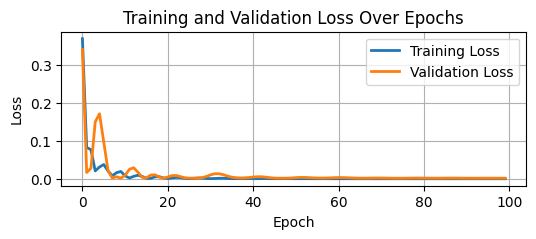

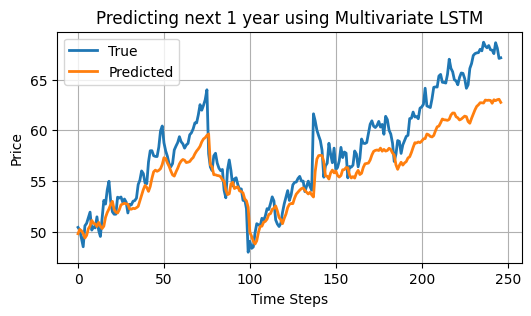

ValueError: x and y must have same first dimension, but have shapes (252,) and (247,)

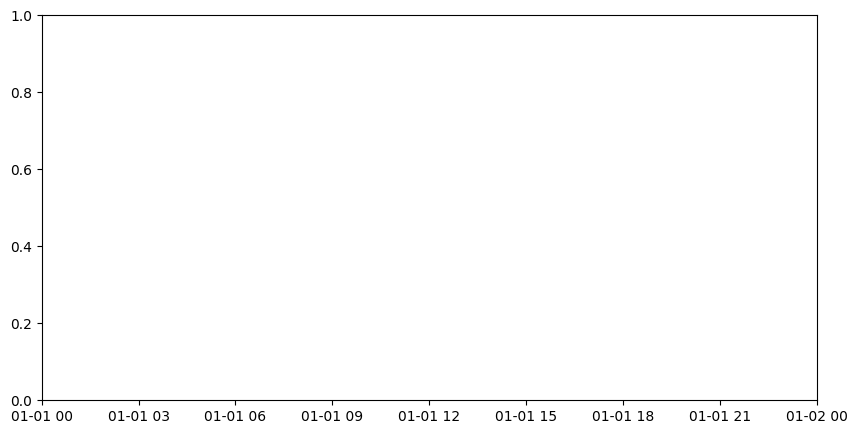

In [214]:
# Load the data
df = pd.read_csv("Data/df_stocks.csv")
df['Date'] = pd.to_datetime(df['Date'])

choosen_stock = "GOOG"
look_back = 5

train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = prepare_data_multivariate(df, choosen_stock, features=['Close', 'High', 'Low', 'Open', 'Volume'], look_back=look_back)
# train_X, train_Y, test_X, test_Y, scaler = prepare_data_multivariate(df, choosen_stock, features=['High', 'Low', 'Open', 'Close', 'Volume'], look_back=10)

# Define hyperparameters
input_size = 5  # Number of input features (High, Low, Open, Close, Volume)
hidden_sizes = 64  # Number of hidden units in the LSTM
num_layers = 1  # Number of LSTM layers
output_size = 1  # Number of output features (Close price)
learning_rate = 0.02
num_epochs = 100

# Create the model
model, loss, train_rmse, valid_rmse, test_rmse, train_mape, valid_mape, test_mape = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler, visualize=True)
# model, loss, train_rmse, test_rmse, train_mape, test_mape = train_evaluate_lstm_multivariate(input_size, hidden_sizes, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y, test_X, test_Y, scaler, visualize=True)

print(model)
print("test_rmse: ", round(test_rmse, 2))
print("test_mape: ", round(test_mape, 2))

# 6. <a id='toc6_'></a>[Feature Importance](#toc0_)

In [182]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import shap
import matplotlib.pyplot as plt

# Step 1: Load and preprocess your dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

def preprocess_data(data, look_back):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    train_size = int(len(data) * 0.70)
    valid_size = int(len(data) * 0.15)
    train_data = data[:train_size]
    valid_data = data[train_size:train_size+valid_size]
    test_data = data[train_size+valid_size-look_back:]
    
    train_X, train_Y = create_sequences(train_data, look_back)
    valid_X, valid_Y = create_sequences(valid_data, look_back)
    test_X, test_Y = create_sequences(test_data, look_back)
    
    train_X = torch.Tensor(train_X)
    train_Y = torch.Tensor(train_Y)
    valid_X = torch.Tensor(valid_X)
    valid_Y = torch.Tensor(valid_Y)
    test_X = torch.Tensor(test_X)
    test_Y = torch.Tensor(test_Y)
    
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler

# Step 2: Define your multivariate LSTM model
class MultivariateLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Step 3: Train your multivariate LSTM model
def train_multivariate_lstm(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y):
    model = MultivariateLSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_X)
        optimizer.zero_grad()
        loss = criterion(outputs.view(-1), train_Y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    return model, train_losses

# Step 4: Calculate feature importance using SHAP
def calculate_shap_values(model, test_X):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(test_X)
    shap_feature_importance = np.abs(shap_values).mean(axis=0)
    return shap_feature_importance

# Step 5: Visualize feature importance
def visualize_feature_importance(feature_importance, features):
    plt.figure(figsize=(8, 4))
    plt.bar(features, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance in Stock Price Prediction')
    plt.xticks(rotation=45)
    plt.show()

# Main function
# if __name__ == '__main__':
#file_path = 'your_data.csv'  # Replace with the path to your dataset
look_back = 10
input_size = 5  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100
    
# data = load_data(file_path)
data = df[df["Stock"] == "GOOG"]
data = data[["Close", "High", "Low", "Open", "Volume"]]

train_X, train_Y, valid_X, valid_Y, test_X, test_Y, scaler = preprocess_data(data, look_back)
    
model, train_losses = train_multivariate_lstm(input_size, hidden_size, num_layers, output_size, learning_rate, num_epochs, train_X, train_Y)
    
shap_feature_importance = calculate_shap_values(model, test_X)
    
features = ["High", "Low", "Open", "Close", "Volume"]
visualize_feature_importance(shap_feature_importance, features)

ValueError: masker cannot be None.